In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jackknife import Jackknife

In [2]:
df = open("out/vector/data/correlators/run_vector_folded_ml_4.txt", "r")
jf = open("out/vector/data/correlators/run_vector_jack.txt", "r")

d = df.readlines()

corr_jack = []
for line in d:
    jack = np.zeros(25)
    for i in range(25):
        jack[i]  = float(jf.readline())
    corr_jack.append(Jackknife())
    corr_jack[-1].mean = float((line.split())[0])
    corr_jack[-1].jack = jack
        
df.close()
jf.close()

corr_full = np.zeros(len(corr_jack))
cov_corr_full = np.zeros((len(corr_jack), len(corr_jack)))
for t_a in range(len(corr_jack)):
    corr_full[t_a] = corr_jack[t_a].mean
    for t_b in range(len(corr_jack)):
        cov_corr_full[t_a, t_b] = corr_jack[t_a].covariance(corr_jack[t_b])

#corr_full = corr_full[0:35]
#cov_corr_full = cov_corr_full[0:35, 0:35]
df = open("out/vector/data/fits/direct_fit_double.txt")
em = open("out/vector/data/fits/eff_mass_fit_full.txt")

t = []
m_df = []
m_df_err = []
m_em = []
m_em_err = []

for l in em.readlines():
    t.append(float(l.split()[0]))
    m_em.append(float(l.split()[1]))
    m_em_err.append(float(l.split()[2]))
    l = df.readline()
    if float(l.split()[0]) == 10:
        C0 = float(l.split()[1])
        m0 = float(l.split()[3])
        err_m0 = float(l.split()[4])
        C1 = float(l.split()[5])
        m1 = float(l.split()[7])
    m_df.append(float(l.split()[3]))
    m_df_err.append(float(l.split()[4]))

df.close()
em.close()


Text(0.5, 1.0, 'Best fit')

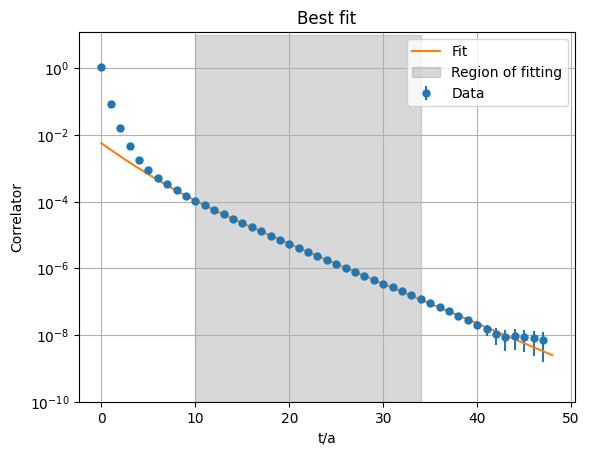

In [3]:
plt.errorbar(range(len(corr_full)), corr_full, np.sqrt(np.diagonal(cov_corr_full)), fmt="o", markersize=5, label="Data")
x_grid = np.linspace(0, len(corr_full), 100)
plt.plot(x_grid, C0*np.exp(-m0*(x_grid)) + C1*np.exp(-m1*(x_grid)), label="Fit")
plt.fill_between([10, 34], [10, 10], [1e-10, 1e-10], color="grey", alpha = 0.3, label="Region of fitting")
plt.semilogy()
plt.legend(loc = "upper right")
plt.ylim(1e-10, 12)
plt.grid()
plt.xlabel(r"t/a")
plt.ylabel(r"Correlator")
plt.title("Best fit")

/data/knuth/home/dtoniolo/Analysis_spectral_densities/jackknife.py:84: RuntimeWarning: invalid value encountered in arccosh
  res.mean = f(self.mean)
/data/knuth/home/dtoniolo/Analysis_spectral_densities/jackknife.py:85: RuntimeWarning: invalid value encountered in arccosh
  res.jack = f(self.jack)


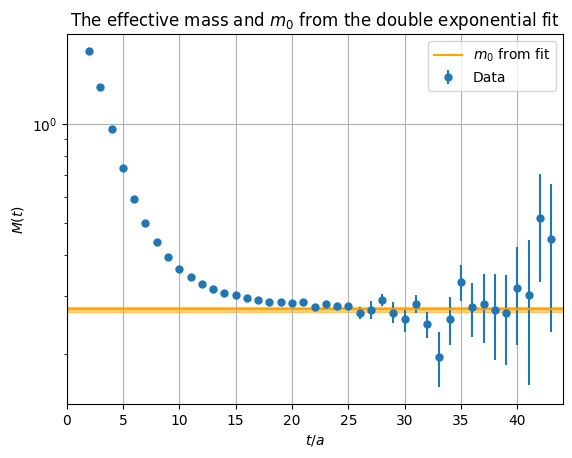

In [4]:
em = np.zeros(0)
err_em = np.zeros(0)
em_jack = []
for t in range(2, len(corr_full) - 1):
    em_jack.append(((corr_jack[t + 1] + corr_jack[t - 1])/(corr_jack[t] * 2.0)).der_function(np.acosh))
    em = np.append(em, em_jack[-1].mean)
    err_em = np.append(err_em, np.sqrt(em_jack[-1].variance()))

plt.errorbar(range(2, len(corr_full) - 1), em, err_em, fmt="o", markersize=5, label="Data")
x_grid = np.linspace(0, 48, 50)
#y_grid = np.acosh((C0*np.exp(-m0*(x_grid + 1)) + C1*np.exp(-m1*(x_grid + 1)) + C0*np.exp(-m0*(x_grid - 1)) + C1*np.exp(-m1*(x_grid - 1)))/\
                  #(2*(C0*np.exp(-m0*(x_grid)) + C1*np.exp(-m1*(x_grid)))))
plt.plot(x_grid, np.full(50, m0), label = r"$m_0$ from fit", color = "orange")
plt.fill_between(x_grid, np.full(50, m0-err_m0), np.full(50, m0+err_m0), alpha = 0.5, color = "orange" )
plt.semilogy()
plt.xlim(0.0, 44)
#plt.ylim(0.12, 0.5)
plt.xlabel(r"$t/a$")
plt.ylabel(r"$M(t)$")
plt.title(r"The effective mass and $m_0$ from the double exponential fit")
plt.legend()
plt.grid()

Text(0.5, 1.0, 'Difference of $m_0$ estimated with direct fit and effective mass')

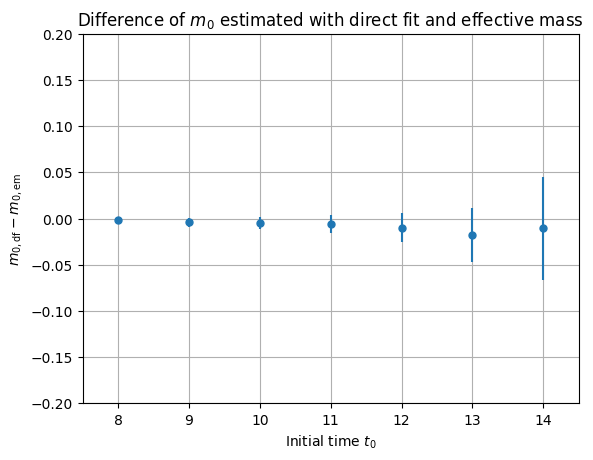

In [5]:
plt.errorbar(range(len(m_df)), np.array(m_df) - np.array(m_em), np.sqrt(np.array(m_df_err)**2.0 +np.array(m_df_err)**2.0), fmt="o", markersize = 5)
plt.grid()
plt.xlim(7.5, 14.5)
plt.ylim(-0.2, 0.2)
plt.xlabel(r"Initial time $t_0$")
plt.ylabel(r"$m_{0, \mathrm{df}} - m_{0, \mathrm{em}}$")
plt.title(r"Difference of $m_0$ estimated with direct fit and effective mass")

Text(0.5, 1.0, 'Difference of $m_0$ estimated with direct fit and effective mass')

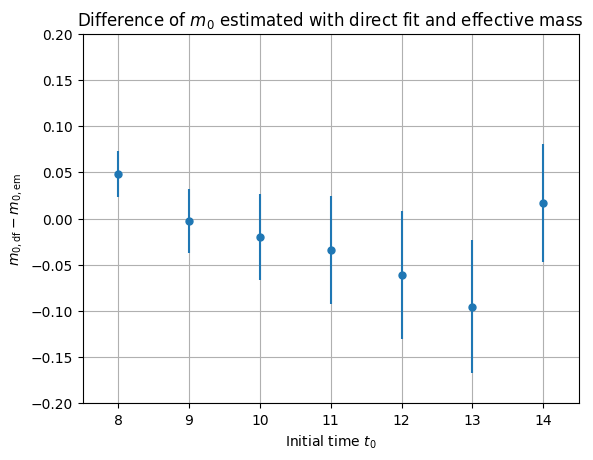

In [6]:
df = open("out/vector/data/fits/direct_fit_double.txt")
em = open("out/vector/data/fits/eff_mass_fit_full.txt")

t = []
m_df = []
m_df_err = []
m_em = []
m_em_err = []

for l in em.readlines():
    t.append(float(l.split()[0]))
    m_em.append(float(l.split()[3]))
    m_em_err.append(float(l.split()[4]))
    l = df.readline()
    if float(l.split()[0]) == 10:
        C0 = float(l.split()[1])
        m0 = float(l.split()[3])
        err_m0 = float(l.split()[4])
        C1 = float(l.split()[5])
        m1 = float(l.split()[7])
    m_df.append(float(l.split()[7]))
    m_df_err.append(float(l.split()[8]))

df.close()
em.close()

plt.errorbar(range(len(m_df)), np.array(m_df) - np.array(m_em), np.sqrt(np.array(m_df_err)**2.0 +np.array(m_df_err)**2.0), fmt="o", markersize = 5)
plt.grid()
plt.xlim(7.5, 14.5)
plt.ylim(-0.2, 0.2)
plt.xlabel(r"Initial time $t_0$")
plt.ylabel(r"$m_{0, \mathrm{df}} - m_{0, \mathrm{em}}$")
plt.title(r"Difference of $m_0$ estimated with direct fit and effective mass")